# Push SWAG

## Introduction

In this notebook, we run SWAG using PusH. SWAG stands for Stochastic Weight Averaging Gaussian, and it is used to build a distribution of parameters for a pre trained network by averaging parameter values over a set number of swag epochs. We begin by training a standard neural network for some number of epochs, then we start tracking and calculating the first and second moments of our model's parameters. The first moment is a running average of our parameters, updated after each swag epoch. The second moment is simply the first moment squared. After training for swag epochs, we use the first and second moments to sample parameter states.

To get an inference result, we choose to sample say 20 parameter states, and average the predictions from these 20. The first and second moment defines our distribution to sample from, and can be a simple gaussian.

### Dataset

In [1]:
import math
from bdl import SineWithNoiseDataset

D = 1                                  # dimensions
N = 2048                               # number of points
train_begin_radians = -2 * math.pi     # left interval
train_end_radians = 2 * math.pi        # right interval

# Define the dataset as a PyTorch dataset
dataset = SineWithNoiseDataset(N, D, train_begin_radians, train_end_radians)

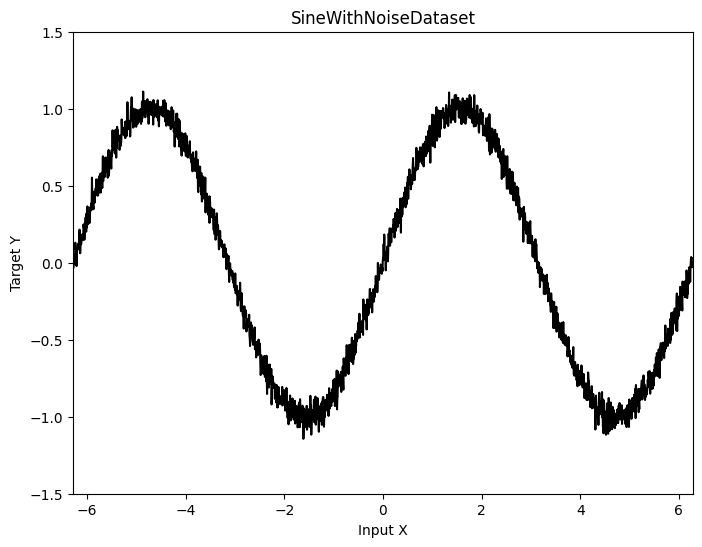

In [2]:
import matplotlib.pyplot as plt

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.plot(dataset.xs, dataset.ys, c ='black')
plt.title('SineWithNoiseDataset')
plt.xlabel('Input X')
plt.ylabel('Target Y')
plt.xlim(train_begin_radians, train_end_radians)
plt.ylim(-1.5, 1.5)
plt.show()

In [3]:
# Import the neural network
from bdl import MiniNN, BiggerNN

In [4]:
import torch
import push.bayes.swag
from torch.utils.data import DataLoader



# 1. Create dataloader
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 2. Model hyperparameters
n = 2
input_dim = 1
output_dim = 1
hidden_dim = 64

# 3. Training parameters
swag_epochs = 1
pretrain_epochs = 1
lr = 1e-3
loss_fn = torch.nn.MSELoss()

two_particle_mswag = push.bayes.swag.train_mswag(
    dataloader,
    loss_fn,
    pretrain_epochs,
    swag_epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices = 2,
    num_models = 2,
    lr = lr
)



100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Average epoch loss tensor(0.4894)


100%|██████████| 1/1 [00:00<00:00,  8.35it/s]


In [5]:
import numpy as np
test_begin_radians = -8 * math.pi
test_end_radians = 8 * math.pi
oos_dataset = SineWithNoiseDataset(N, D, test_begin_radians, test_end_radians)
test_dataloader = DataLoader(oos_dataset, batch_size=64, shuffle=False)
oos_xs = oos_dataset.xs
oos_ys = oos_dataset.ys

# Extract the data
xs = dataset.xs
ys = dataset.ys

# Flatten our x values for out of sample
x_flat = xs.view(-1).numpy()
oos_x_flat = oos_xs.view(-1).numpy()

In [10]:
two_model_outputs = two_particle_mswag.posterior_pred(test_dataloader, loss_fn, num_samples=2, mode=["mean","median","min","max"], f_reg=True)

0.5753

In [7]:
# min_two_model_outputs = two_particle_mswag.posterior_pred(test_dataloader, loss_fn, num_samples=2, mode="min", f_reg=True)
# max_two_model_outputs = two_particle_mswag.posterior_pred(test_dataloader, loss_fn, num_samples=2, mode="max", f_reg=True)
# mean_two_model_outputs = two_particle_mswag.posterior_pred(test_dataloader, loss_fn, num_samples=2, mode="mean", f_reg=True)



In [8]:
# print("min_two_model_outputs: ", min_two_model_outputs)
# print("max_two_model_outputs: ", max_two_model_outputs)
# print("mean_two_model_outputs: ", mean_two_model_outputs)